In [1]:
!pip install torcheval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 13.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/train.zip train.zip
!unzip train.zip

Mounted at /content/drive
Archive:  train.zip
 extracting: train/annotations.xlsx  
 extracting: train/images/Image_0000_04_0_0_4.png  
 extracting: train/images/Image_0001_04_0_0_4.png  
 extracting: train/images/Image_0002_04_0_0_4.png  
 extracting: train/images/Image_0003_04_0_0_4.png  
 extracting: train/images/Image_0004_04_0_0_4.png  
 extracting: train/images/Image_0005_04_0_0_4.png  
 extracting: train/images/Image_0006_04_0_0_4.png  
 extracting: train/images/Image_0007_04_0_0_4.png  
 extracting: train/images/Image_0008_04_0_0_4.png  
 extracting: train/images/Image_0009_04_0_0_4.png  
 extracting: train/images/Image_0010_04_0_0_4.png  
 extracting: train/images/Image_0011_04_0_0_4.png  
 extracting: train/images/Image_0012_04_0_0_4.png  
 extracting: train/images/Image_0013_04_0_0_4.png  
 extracting: train/images/Image_0014_04_0_0_4.png  
 extracting: train/images/Image_0015_04_0_0_4.png  
 extracting: train/images/Image_0016_04_0_0_4.png  
 extracting: train/images/Image_

In [3]:
import torchvision
import torcheval
import torchvision.models as models
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import pandas as pd
import os
import numpy as np
import PIL

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_excel(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
# TO BE FIXEDDD
    def __len__(self):
        #return len(self.img_labels)
        return 512

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = PIL.Image.open(img_path)
        #print(image.size)
        T1 = torchvision.transforms.Resize((250,250))
        T2 = torchvision.transforms.ToTensor()
        image = T1(image)
        #print(image.size)
        image = T2(image)
        #print(image.shape)
        image = image[:-1]
        assert(image.shape[0]==3)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [13]:
suture_dataset = CustomImageDataset("train/annotations.xlsx","./train/images")
batch_size = 64
validation_split = .1
shuffle_dataset = True
random_seed= 42

dataset_size = len(suture_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(suture_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(suture_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg = torchvision.models.vgg19(pretrained=True)
model_vgg.classifier[6] = nn.Linear(in_features=4096,out_features=1,bias=True)
model_vgg.requires_grad_(False)
for param in model_vgg.classifier[6].parameters():
  param.requires_grad=True
model_vgg.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [29]:
optimizer = torch.optim.Adam(model_vgg.classifier[6].parameters(), lr=0.001)

In [33]:
from torcheval.metrics import R2Score

num_epochs=30
loss_fn = torch.nn.MSELoss()

val_loss_arr = []
train_loss_arr = []

val_R2_arr = []
train_R2_arr = []

R2metric = (R2Score()).to(device)

for epoch in range(num_epochs):
    # Train:
    running_loss = 0
    cnt = 0
    R2_train_loss = 0
    for batch_index, (images, labels) in enumerate(train_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = model_vgg(images).flatten()
      loss = loss_fn(output,labels.float())
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      R2metric.update(output,labels)
      R2_train_loss += R2metric.compute()

    epoch_loss = running_loss/cnt
    R2_train_loss /= cnt

    train_loss_arr.append(epoch_loss)
    train_R2_arr.append(R2_train_loss)
    

    # Validation:
    val_loss = 0
    R2_val_loss = 0
    #val_accuracy = 0
    cnt = 0
    cnt2=0
    for batch_index, (images,labels) in enumerate(validation_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      with torch.no_grad():
        output = model_vgg(images).flatten()
        loss = loss_fn(output,labels.float())
        val_loss += loss.item()
        #pred = torch.round(output)
        #val_accuracy += torch.sum(pred==labels).item()
        #cnt2+= images.shape[0]
        R2metric.update(output,labels)
        R2_val_loss += R2metric.compute()
    
      
    #val_accuracy /= cnt2
    epoch_val_loss = val_loss/cnt
    R2_val_loss /= cnt

    val_loss_arr.append(epoch_val_loss)
    val_R2_arr.append(R2_val_loss)

    #print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} Validation Accuracy: {val_accuracy}')
    print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} R2_train_loss: {R2_train_loss} R2_val_loss: {R2_val_loss}')


epoch: 0 Train loss: 7.844161078333855 Validation Loss: 1.7358744144439697 R2_train_loss: -7.023075103759766 R2_val_loss: -3.763256072998047
epoch: 1 Train loss: 3.1466612219810486 Validation Loss: 3.5727853775024414 R2_train_loss: -2.7183351516723633 R2_val_loss: -2.3086776733398438
epoch: 2 Train loss: 2.264086067676544 Validation Loss: 1.6900938749313354 R2_train_loss: -1.938865065574646 R2_val_loss: -1.6673352718353271
epoch: 3 Train loss: 1.605746939778328 Validation Loss: 1.385225534439087 R2_train_loss: -1.4147940874099731 R2_val_loss: -1.2328221797943115
epoch: 4 Train loss: 1.44429412484169 Validation Loss: 1.7367769479751587 R2_train_loss: -1.075472354888916 R2_val_loss: -0.965935468673706
epoch: 5 Train loss: 1.204833872616291 Validation Loss: 1.1746037006378174 R2_train_loss: -0.8407797813415527 R2_val_loss: -0.7668040990829468
epoch: 6 Train loss: 1.1984251290559769 Validation Loss: 1.053742527961731 R2_train_loss: -0.677701473236084 R2_val_loss: -0.6123321056365967
epoch:

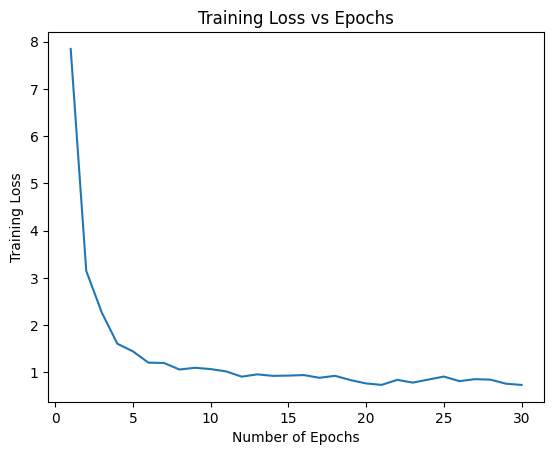

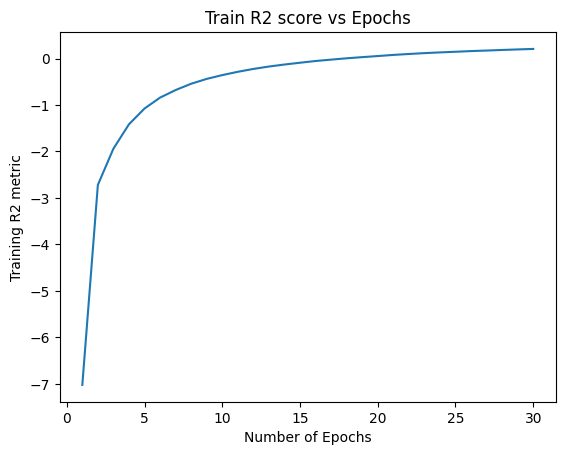

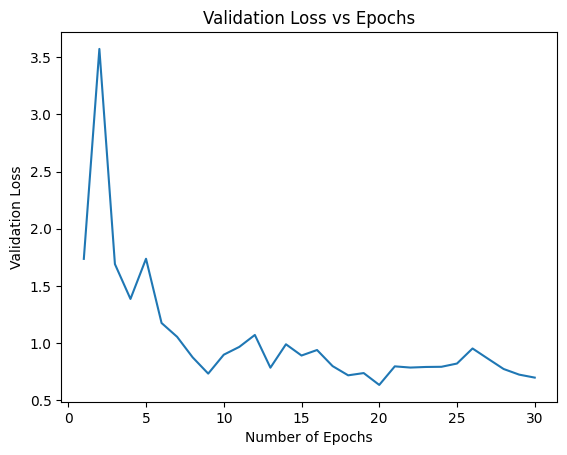

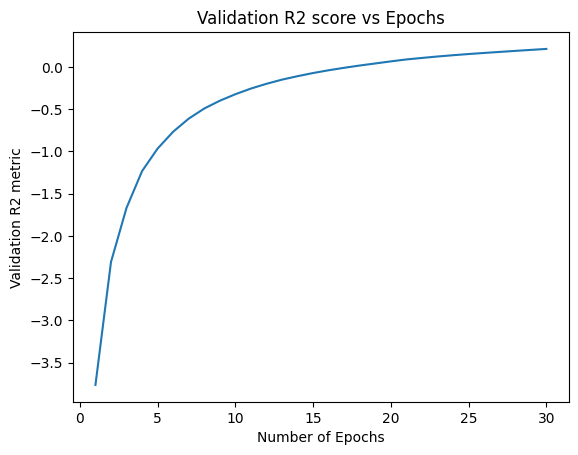

In [38]:
plt.plot(range(1,num_epochs+1),train_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in train_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Training R2 metric")
plt.title("Train R2 score vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),val_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in val_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Validation R2 metric")
plt.title("Validation R2 score vs Epochs")
plt.show()



Batch Norm

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg = torchvision.models.vgg19_bn(pretrained=True)
model_vgg.classifier[6] = nn.Linear(in_features=4096,out_features=1,bias=True)
model_vgg.requires_grad_(False)
for param in model_vgg.classifier[6].parameters():
  param.requires_grad=True
model_vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [42]:
from torcheval.metrics import R2Score
optimizer = torch.optim.Adam(model_vgg.classifier[6].parameters(), lr=0.001)
num_epochs=30
loss_fn = torch.nn.MSELoss()

val_loss_arr = []
train_loss_arr = []

val_R2_arr = []
train_R2_arr = []

R2metric = (R2Score()).to(device)

for epoch in range(num_epochs):
    # Train:
    running_loss = 0
    cnt = 0
    R2_train_loss = 0
    for batch_index, (images, labels) in enumerate(train_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = model_vgg(images).flatten()
      loss = loss_fn(output,labels.float())
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      R2metric.update(output,labels)
      R2_train_loss += R2metric.compute()

    epoch_loss = running_loss/cnt
    R2_train_loss /= cnt

    train_loss_arr.append(epoch_loss)
    train_R2_arr.append(R2_train_loss)
    

    # Validation:
    val_loss = 0
    R2_val_loss = 0
    #val_accuracy = 0
    cnt = 0
    cnt2=0
    for batch_index, (images,labels) in enumerate(validation_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      with torch.no_grad():
        output = model_vgg(images).flatten()
        loss = loss_fn(output,labels.float())
        val_loss += loss.item()
        #pred = torch.round(output)
        #val_accuracy += torch.sum(pred==labels).item()
        #cnt2+= images.shape[0]
        R2metric.update(output,labels)
        R2_val_loss += R2metric.compute()
    
      
    #val_accuracy /= cnt2
    epoch_val_loss = val_loss/cnt
    R2_val_loss /= cnt

    val_loss_arr.append(epoch_val_loss)
    val_R2_arr.append(R2_val_loss)

    #print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} Validation Accuracy: {val_accuracy}')
    print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} R2_train_loss: {R2_train_loss} R2_val_loss: {R2_val_loss}')


epoch: 0 Train loss: 8.205618128180504 Validation Loss: 2.993551254272461 R2_train_loss: -8.79129409790039 R2_val_loss: -4.039100646972656
epoch: 1 Train loss: 4.179867744445801 Validation Loss: 3.3490676879882812 R2_train_loss: -3.158445358276367 R2_val_loss: -2.762775182723999
epoch: 2 Train loss: 2.142711818218231 Validation Loss: 1.473914384841919 R2_train_loss: -2.2553508281707764 R2_val_loss: -1.8985679149627686
epoch: 3 Train loss: 1.9959543496370316 Validation Loss: 1.0826973915100098 R2_train_loss: -1.6584481000900269 R2_val_loss: -1.465383529663086
epoch: 4 Train loss: 1.391368754208088 Validation Loss: 1.716145634651184 R2_train_loss: -1.2606213092803955 R2_val_loss: -1.1407415866851807
epoch: 5 Train loss: 1.3304711431264877 Validation Loss: 1.1510084867477417 R2_train_loss: -1.0060573816299438 R2_val_loss: -0.9155222177505493
epoch: 6 Train loss: 1.2255456894636154 Validation Loss: 0.9970057010650635 R2_train_loss: -0.8098257780075073 R2_val_loss: -0.7440272569656372
epoch

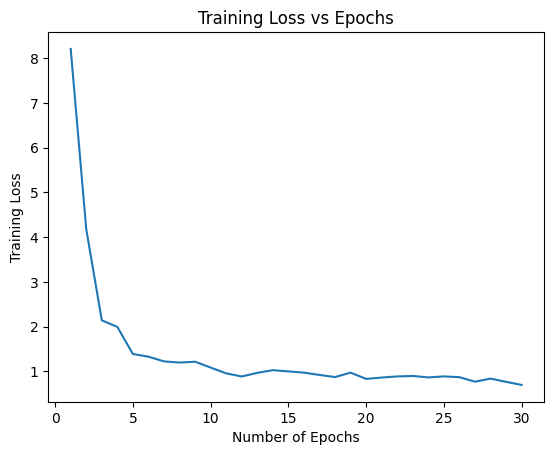

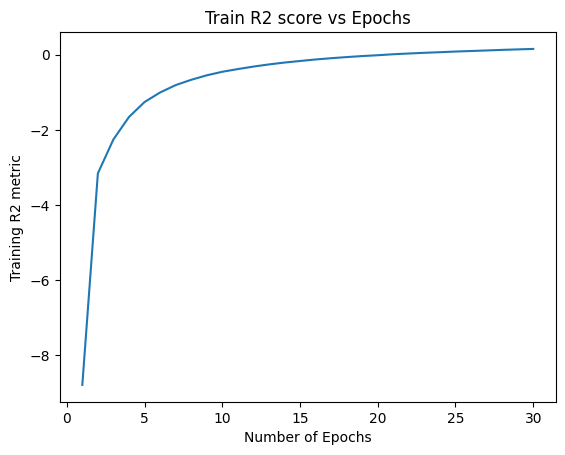

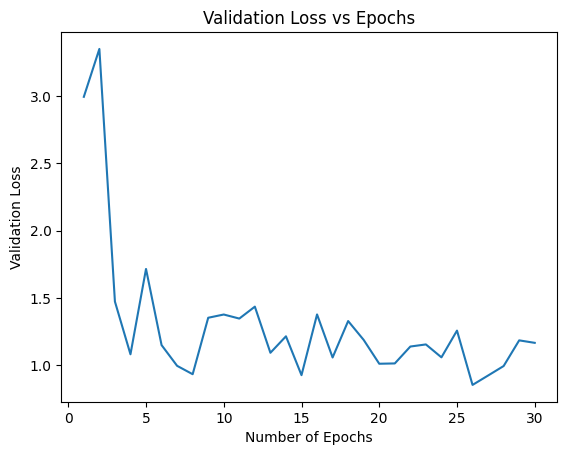

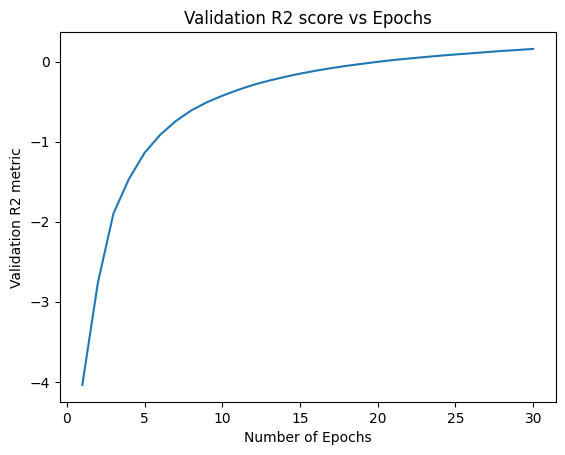

In [43]:
plt.plot(range(1,num_epochs+1),train_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in train_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Training R2 metric")
plt.title("Train R2 score vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),val_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in val_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Validation R2 metric")
plt.title("Validation R2 score vs Epochs")
plt.show()



Dropout

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg = torchvision.models.vgg19(pretrained=True)
model_vgg.classifier[6] = nn.Linear(in_features=4096,out_features=1,bias=True)
model_vgg.classifier[2] = nn.Dropout(p=0.0)
model_vgg.classifier[5] = nn.Dropout(p=0.0)
model_vgg.requires_grad_(False)
for param in model_vgg.classifier[6].parameters():
  param.requires_grad=True
model_vgg.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [46]:
from torcheval.metrics import R2Score
optimizer = torch.optim.Adam(model_vgg.classifier[6].parameters(), lr=0.001)
num_epochs=30
loss_fn = torch.nn.MSELoss()

val_loss_arr = []
train_loss_arr = []

val_R2_arr = []
train_R2_arr = []

R2metric = (R2Score()).to(device)

for epoch in range(num_epochs):
    # Train:
    running_loss = 0
    cnt = 0
    R2_train_loss = 0
    for batch_index, (images, labels) in enumerate(train_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = model_vgg(images).flatten()
      loss = loss_fn(output,labels.float())
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      R2metric.update(output,labels)
      R2_train_loss += R2metric.compute()

    epoch_loss = running_loss/cnt
    R2_train_loss /= cnt

    train_loss_arr.append(epoch_loss)
    train_R2_arr.append(R2_train_loss)
    

    # Validation:
    val_loss = 0
    R2_val_loss = 0
    #val_accuracy = 0
    cnt = 0
    cnt2=0
    for batch_index, (images,labels) in enumerate(validation_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      with torch.no_grad():
        output = model_vgg(images).flatten()
        loss = loss_fn(output,labels.float())
        val_loss += loss.item()
        #pred = torch.round(output)
        #val_accuracy += torch.sum(pred==labels).item()
        #cnt2+= images.shape[0]
        R2metric.update(output,labels)
        R2_val_loss += R2metric.compute()
    
      
    #val_accuracy /= cnt2
    epoch_val_loss = val_loss/cnt
    R2_val_loss /= cnt

    val_loss_arr.append(epoch_val_loss)
    val_R2_arr.append(R2_val_loss)

    #print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} Validation Accuracy: {val_accuracy}')
    print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} R2_train_loss: {R2_train_loss} R2_val_loss: {R2_val_loss}')


epoch: 0 Train loss: 10.10046648979187 Validation Loss: 1.6176199913024902 R2_train_loss: -8.259183883666992 R2_val_loss: -5.060056209564209
epoch: 1 Train loss: 2.076524317264557 Validation Loss: 3.2864670753479004 R2_train_loss: -3.2848596572875977 R2_val_loss: -2.6357569694519043
epoch: 2 Train loss: 2.5495214760303497 Validation Loss: 1.548409342765808 R2_train_loss: -2.2437081336975098 R2_val_loss: -1.9440674781799316
epoch: 3 Train loss: 1.188237264752388 Validation Loss: 1.1809051036834717 R2_train_loss: -1.6033648252487183 R2_val_loss: -1.3966193199157715
epoch: 4 Train loss: 1.218888059258461 Validation Loss: 1.0321896076202393 R2_train_loss: -1.19718599319458 R2_val_loss: -1.0630645751953125
epoch: 5 Train loss: 1.001049354672432 Validation Loss: 0.9402775168418884 R2_train_loss: -0.9199268817901611 R2_val_loss: -0.8177818059921265
epoch: 6 Train loss: 0.9887189045548439 Validation Loss: 0.8705042004585266 R2_train_loss: -0.7087308168411255 R2_val_loss: -0.637831449508667
epo

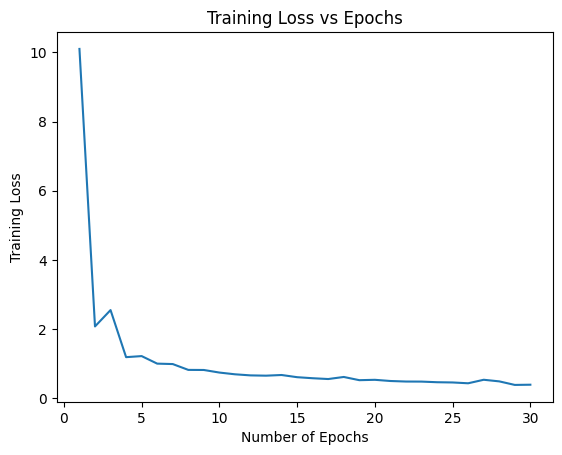

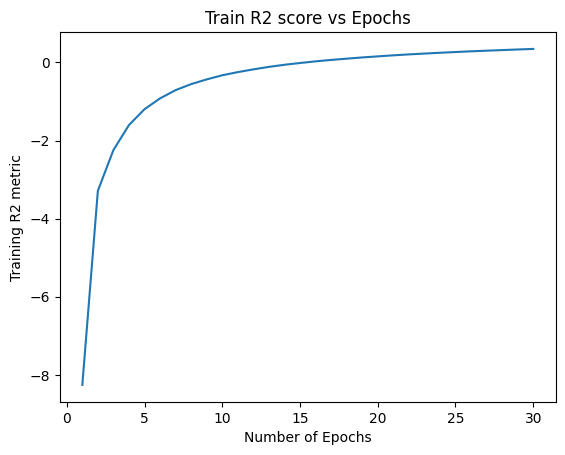

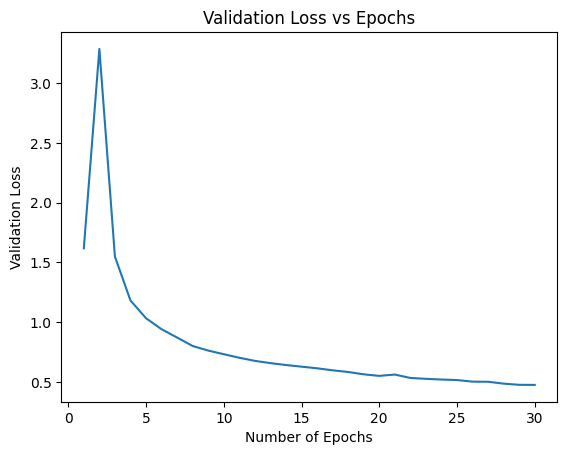

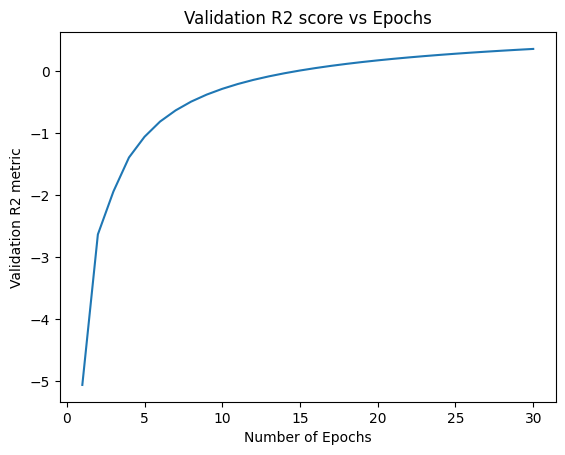

In [47]:
plt.plot(range(1,num_epochs+1),train_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in train_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Training R2 metric")
plt.title("Train R2 score vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),val_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in val_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Validation R2 metric")
plt.title("Validation R2 score vs Epochs")
plt.show()



Freezing Weights

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg = torchvision.models.vgg19(pretrained=True)
model_vgg.classifier[6] = nn.Linear(in_features=4096,out_features=1,bias=True)
model_vgg.requires_grad_(False)
for param in model_vgg.classifier.parameters():
  param.requires_grad=True
model_vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [51]:
from torcheval.metrics import R2Score
optimizer = torch.optim.Adam(model_vgg.classifier.parameters(), lr=0.001)
num_epochs=30
loss_fn = torch.nn.MSELoss()

val_loss_arr = []
train_loss_arr = []

val_R2_arr = []
train_R2_arr = []

R2metric = (R2Score()).to(device)

for epoch in range(num_epochs):
    # Train:
    running_loss = 0
    cnt = 0
    R2_train_loss = 0
    for batch_index, (images, labels) in enumerate(train_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = model_vgg(images).flatten()
      loss = loss_fn(output,labels.float())
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      R2metric.update(output,labels)
      R2_train_loss += R2metric.compute()

    epoch_loss = running_loss/cnt
    R2_train_loss /= cnt

    train_loss_arr.append(epoch_loss)
    train_R2_arr.append(R2_train_loss)
    

    # Validation:
    val_loss = 0
    R2_val_loss = 0
    #val_accuracy = 0
    cnt = 0
    cnt2=0
    for batch_index, (images,labels) in enumerate(validation_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      with torch.no_grad():
        output = model_vgg(images).flatten()
        loss = loss_fn(output,labels.float())
        val_loss += loss.item()
        #pred = torch.round(output)
        #val_accuracy += torch.sum(pred==labels).item()
        #cnt2+= images.shape[0]
        R2metric.update(output,labels)
        R2_val_loss += R2metric.compute()
    
      
    #val_accuracy /= cnt2
    epoch_val_loss = val_loss/cnt
    R2_val_loss /= cnt

    val_loss_arr.append(epoch_val_loss)
    val_R2_arr.append(R2_val_loss)

    #print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} Validation Accuracy: {val_accuracy}')
    print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} R2_train_loss: {R2_train_loss} R2_val_loss: {R2_val_loss}')


epoch: 0 Train loss: 75.44592159986496 Validation Loss: 12.55031967163086 R2_train_loss: -70.100830078125 R2_val_loss: -44.8050537109375
epoch: 1 Train loss: 5.722483932971954 Validation Loss: 3.0485928058624268 R2_train_loss: -31.897357940673828 R2_val_loss: -23.64353370666504
epoch: 2 Train loss: 3.043998584151268 Validation Loss: 2.0873632431030273 R2_train_loss: -18.95176124572754 R2_val_loss: -16.03683853149414
epoch: 3 Train loss: 2.2350288331508636 Validation Loss: 1.5800210237503052 R2_train_loss: -13.637550354003906 R2_val_loss: -12.095731735229492
epoch: 4 Train loss: 1.546122059226036 Validation Loss: 1.439616084098816 R2_train_loss: -10.626660346984863 R2_val_loss: -9.66691780090332
epoch: 5 Train loss: 1.4019016474485397 Validation Loss: 1.8916159868240356 R2_train_loss: -8.723633766174316 R2_val_loss: -8.037277221679688
epoch: 6 Train loss: 1.5078711956739426 Validation Loss: 1.6786298751831055 R2_train_loss: -7.324780464172363 R2_val_loss: -6.878324031829834
epoch: 7 Tra

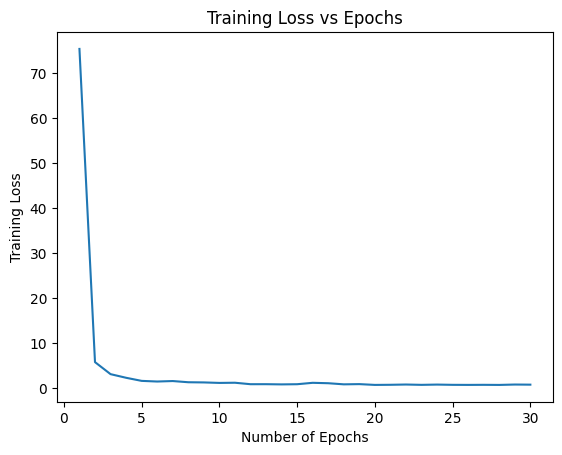

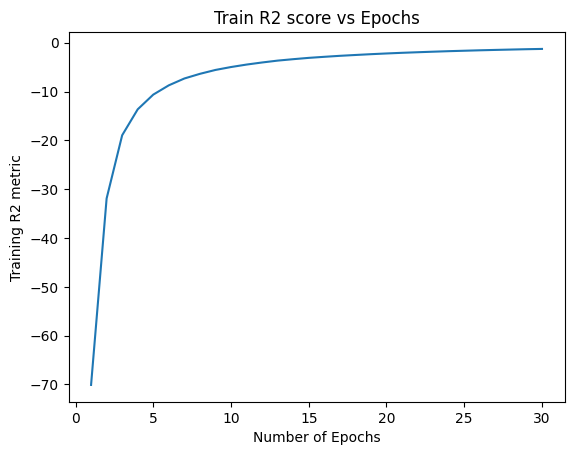

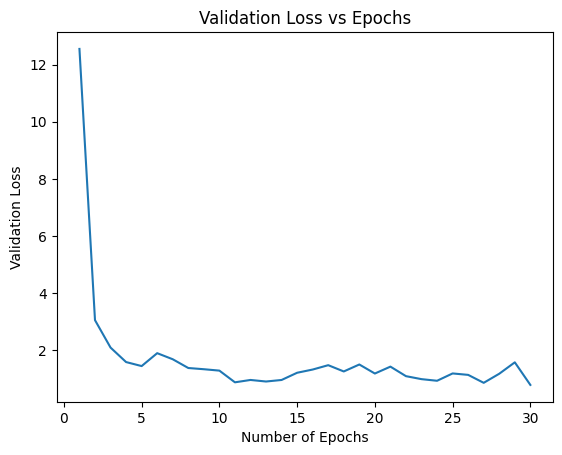

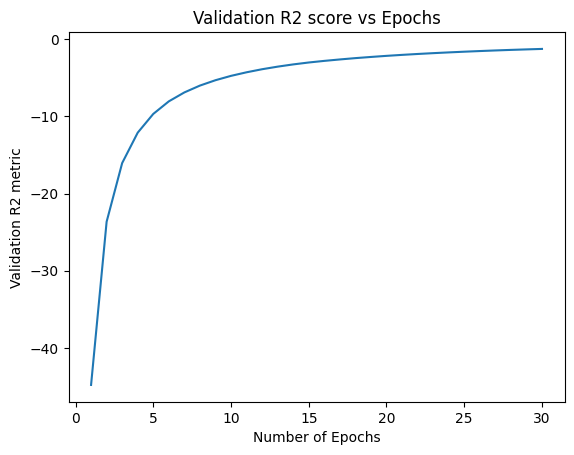

In [52]:
plt.plot(range(1,num_epochs+1),train_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in train_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Training R2 metric")
plt.title("Train R2 score vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),val_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in val_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Validation R2 metric")
plt.title("Validation R2 score vs Epochs")
plt.show()



LeakyReLU

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg = torchvision.models.vgg19(pretrained=True)
model_vgg.classifier[6] = nn.Linear(in_features=4096,out_features=1,bias=True)
model_vgg.classifier[1] = nn.LeakyReLU(inplace=True)
model_vgg.classifier[4] = nn.LeakyReLU(inplace=True)
model_vgg.requires_grad_(False)
for param in model_vgg.classifier[6].parameters():
  param.requires_grad=True
model_vgg.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [54]:
from torcheval.metrics import R2Score
optimizer = torch.optim.Adam(model_vgg.classifier[6].parameters(), lr=0.001)
num_epochs=30
loss_fn = torch.nn.MSELoss()

val_loss_arr = []
train_loss_arr = []

val_R2_arr = []
train_R2_arr = []

R2metric = (R2Score()).to(device)

for epoch in range(num_epochs):
    # Train:
    running_loss = 0
    cnt = 0
    R2_train_loss = 0
    for batch_index, (images, labels) in enumerate(train_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = model_vgg(images).flatten()
      loss = loss_fn(output,labels.float())
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      R2metric.update(output,labels)
      R2_train_loss += R2metric.compute()

    epoch_loss = running_loss/cnt
    R2_train_loss /= cnt

    train_loss_arr.append(epoch_loss)
    train_R2_arr.append(R2_train_loss)
    

    # Validation:
    val_loss = 0
    R2_val_loss = 0
    #val_accuracy = 0
    cnt = 0
    cnt2=0
    for batch_index, (images,labels) in enumerate(validation_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      with torch.no_grad():
        output = model_vgg(images).flatten()
        loss = loss_fn(output,labels.float())
        val_loss += loss.item()
        #pred = torch.round(output)
        #val_accuracy += torch.sum(pred==labels).item()
        #cnt2+= images.shape[0]
        R2metric.update(output,labels)
        R2_val_loss += R2metric.compute()
    
      
    #val_accuracy /= cnt2
    epoch_val_loss = val_loss/cnt
    R2_val_loss /= cnt

    val_loss_arr.append(epoch_val_loss)
    val_R2_arr.append(R2_val_loss)

    #print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} Validation Accuracy: {val_accuracy}')
    print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} R2_train_loss: {R2_train_loss} R2_val_loss: {R2_val_loss}')


epoch: 0 Train loss: 8.314091607928276 Validation Loss: 2.0547826290130615 R2_train_loss: -7.936688423156738 R2_val_loss: -4.073873996734619
epoch: 1 Train loss: 3.147356688976288 Validation Loss: 2.936563730239868 R2_train_loss: -2.886754274368286 R2_val_loss: -2.4786477088928223
epoch: 2 Train loss: 2.3707779347896576 Validation Loss: 1.247068166732788 R2_train_loss: -2.0927791595458984 R2_val_loss: -1.7317686080932617
epoch: 3 Train loss: 1.6161939352750778 Validation Loss: 1.587047815322876 R2_train_loss: -1.4681344032287598 R2_val_loss: -1.2978839874267578
epoch: 4 Train loss: 1.5147946178913116 Validation Loss: 1.239242434501648 R2_train_loss: -1.1206226348876953 R2_val_loss: -1.0068159103393555
epoch: 5 Train loss: 1.2569288834929466 Validation Loss: 1.3992761373519897 R2_train_loss: -0.8871222734451294 R2_val_loss: -0.8031306266784668
epoch: 6 Train loss: 1.112997405230999 Validation Loss: 0.9820165038108826 R2_train_loss: -0.7170124053955078 R2_val_loss: -0.6434085369110107
ep

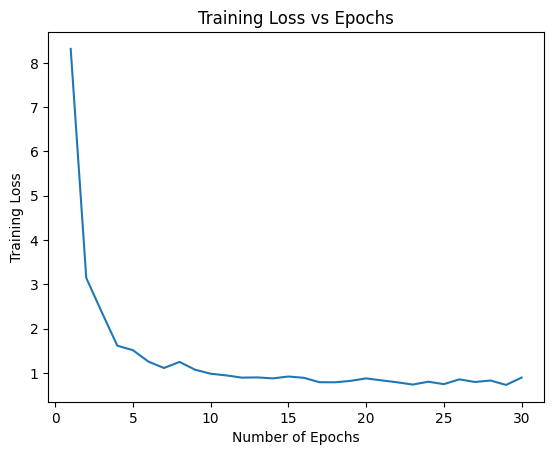

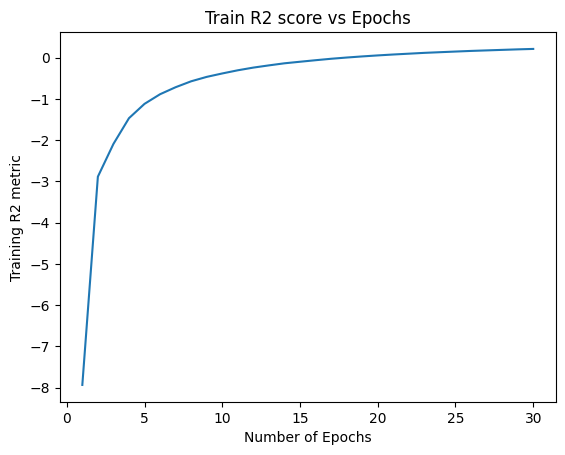

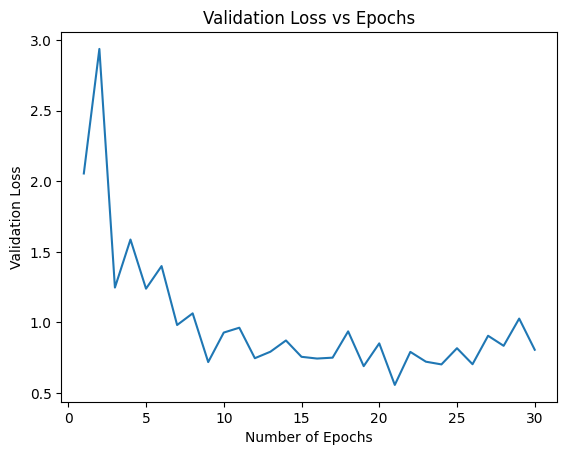

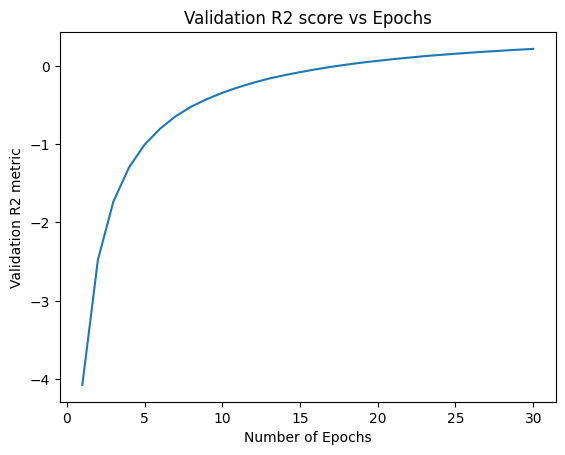

In [55]:
plt.plot(range(1,num_epochs+1),train_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in train_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Training R2 metric")
plt.title("Train R2 score vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),val_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in val_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Validation R2 metric")
plt.title("Validation R2 score vs Epochs")
plt.show()



Sigmoid

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch: 0 Train loss: 7.8103779554367065 Validation Loss: 4.221654891967773 R2_train_loss: -7.683664321899414 R2_val_loss: -3.7649388313293457
epoch: 1 Train loss: 4.153828576207161 Validation Loss: 1.7908645868301392 R2_train_loss: -3.1009929180145264 R2_val_loss: -2.6431713104248047
epoch: 2 Train loss: 2.2799269407987595 Validation Loss: 2.185667037963867 R2_train_loss: -2.124495029449463 R2_val_loss: -1.8464198112487793
epoch: 3 Train loss: 1.8373522758483887 Validation Loss: 1.5482075214385986 R2_train_loss: -1.59620201587677 R2_val_loss: -1.4252159595489502
epoch: 4 Train loss: 1.856571763753891 Validation Loss: 1.6182273626327515 R2_train_loss: -1.271344542503357 R2_val_loss: -1.1658599376678467
epoch: 5 Train loss: 1.609196424484253 Validation Loss: 1.4668065309524536 R2_train_loss: -1.050325632095337 R2_val_loss: -0.9708120822906494
epoch: 6 Train loss: 1.5834043323993683 Validation Loss: 1.4393310546875 R2_train_loss: -0.888679027557373 R2_val_loss: -0.8274686336517334
epoch: 

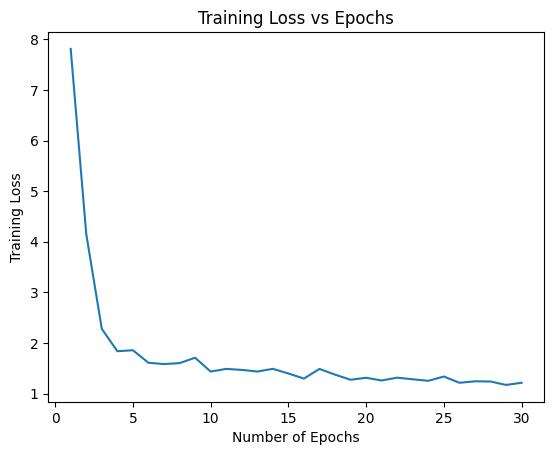

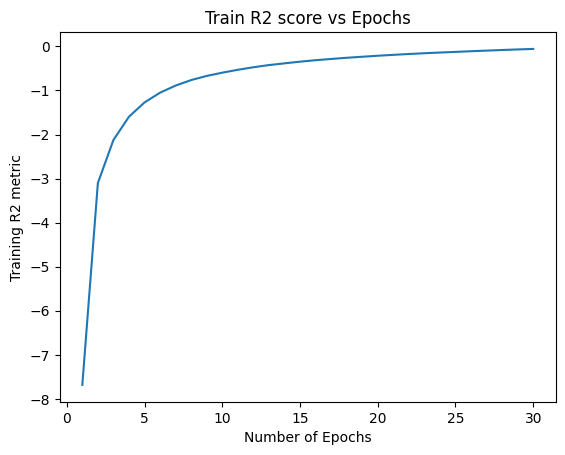

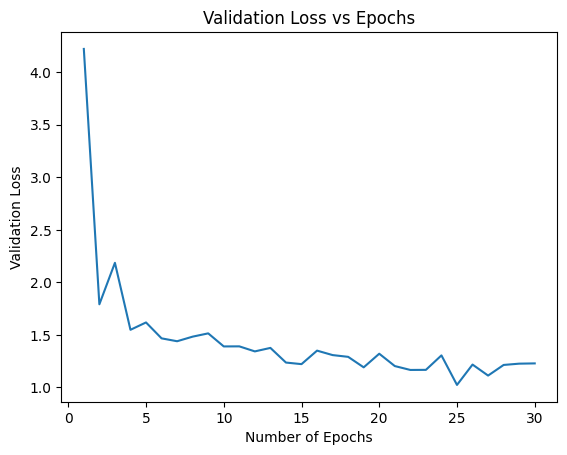

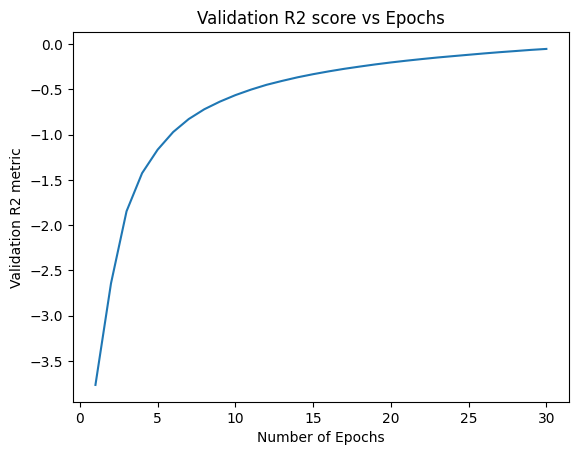

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg = torchvision.models.vgg19(pretrained=True)
model_vgg.classifier[6] = nn.Linear(in_features=4096,out_features=1,bias=True)
model_vgg.classifier[1] = nn.Sigmoid()
model_vgg.classifier[4] = nn.Sigmoid()
for param in model_vgg.classifier[6].parameters():
  param.requires_grad=True
model_vgg.to(device)

from torcheval.metrics import R2Score
optimizer = torch.optim.Adam(model_vgg.classifier[6].parameters(), lr=0.001)
num_epochs=30
loss_fn = torch.nn.MSELoss()

val_loss_arr = []
train_loss_arr = []

val_R2_arr = []
train_R2_arr = []

R2metric = (R2Score()).to(device)

for epoch in range(num_epochs):
    # Train:
    running_loss = 0
    cnt = 0
    R2_train_loss = 0
    for batch_index, (images, labels) in enumerate(train_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = model_vgg(images).flatten()
      loss = loss_fn(output,labels.float())
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      R2metric.update(output,labels)
      R2_train_loss += R2metric.compute()

    epoch_loss = running_loss/cnt
    R2_train_loss /= cnt

    train_loss_arr.append(epoch_loss)
    train_R2_arr.append(R2_train_loss)
    

    # Validation:
    val_loss = 0
    R2_val_loss = 0
    #val_accuracy = 0
    cnt = 0
    cnt2=0
    for batch_index, (images,labels) in enumerate(validation_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      with torch.no_grad():
        output = model_vgg(images).flatten()
        loss = loss_fn(output,labels.float())
        val_loss += loss.item()
        #pred = torch.round(output)
        #val_accuracy += torch.sum(pred==labels).item()
        #cnt2+= images.shape[0]
        R2metric.update(output,labels)
        R2_val_loss += R2metric.compute()
    
      
    #val_accuracy /= cnt2
    epoch_val_loss = val_loss/cnt
    R2_val_loss /= cnt

    val_loss_arr.append(epoch_val_loss)
    val_R2_arr.append(R2_val_loss)

    #print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} Validation Accuracy: {val_accuracy}')
    print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} R2_train_loss: {R2_train_loss} R2_val_loss: {R2_val_loss}')

plt.plot(range(1,num_epochs+1),train_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in train_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Training R2 metric")
plt.title("Train R2 score vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),val_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in val_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Validation R2 metric")
plt.title("Validation R2 score vs Epochs")
plt.show()




Tanh

epoch: 0 Train loss: 9.27949133515358 Validation Loss: 1.7225368022918701 R2_train_loss: -9.844057083129883 R2_val_loss: -4.49542760848999
epoch: 1 Train loss: 3.4612617939710617 Validation Loss: 2.1275782585144043 R2_train_loss: -3.3773303031921387 R2_val_loss: -2.8206710815429688
epoch: 2 Train loss: 2.6770521253347397 Validation Loss: 2.142108678817749 R2_train_loss: -2.3803107738494873 R2_val_loss: -2.08986234664917
epoch: 3 Train loss: 1.9180416911840439 Validation Loss: 1.7270433902740479 R2_train_loss: -1.827757477760315 R2_val_loss: -1.6012115478515625
epoch: 4 Train loss: 1.5461601465940475 Validation Loss: 1.5639134645462036 R2_train_loss: -1.3917632102966309 R2_val_loss: -1.2585923671722412
epoch: 5 Train loss: 1.2087355256080627 Validation Loss: 1.0917315483093262 R2_train_loss: -1.096976399421692 R2_val_loss: -1.0056438446044922
epoch: 6 Train loss: 1.1299165859818459 Validation Loss: 0.9793788194656372 R2_train_loss: -0.8872197270393372 R2_val_loss: -0.8148053884506226
ep

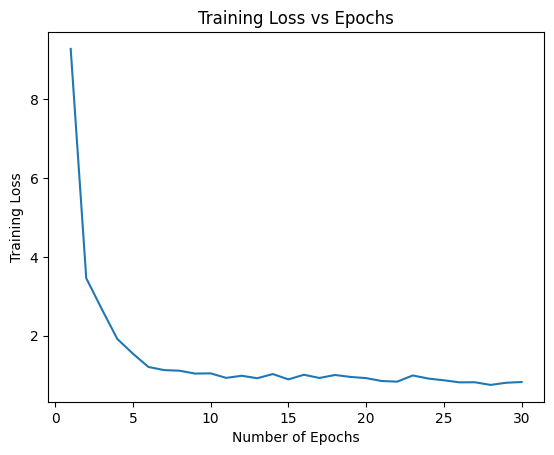

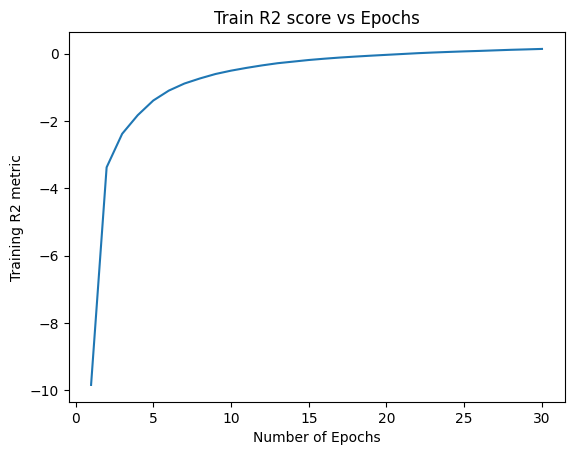

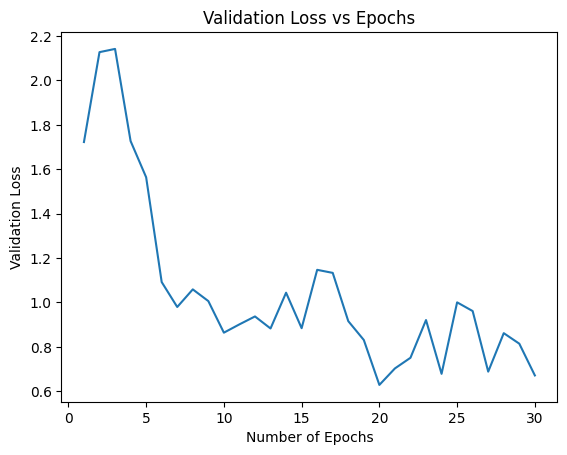

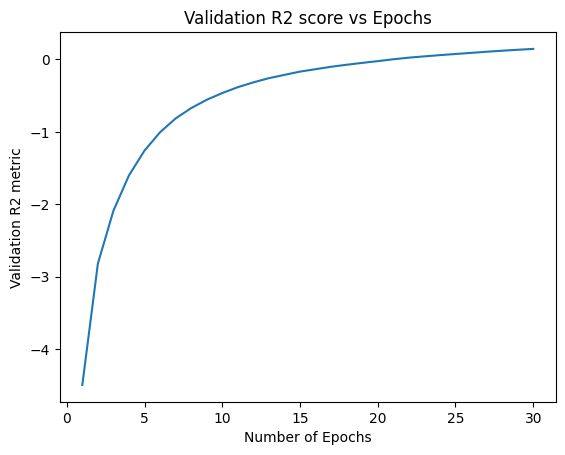

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg = torchvision.models.vgg19(pretrained=True)
model_vgg.classifier[6] = nn.Linear(in_features=4096,out_features=1,bias=True)
model_vgg.classifier[1] = nn.Tanh()
model_vgg.classifier[4] = nn.Tanh()
for param in model_vgg.classifier[6].parameters():
  param.requires_grad=True
model_vgg.to(device)

from torcheval.metrics import R2Score
optimizer = torch.optim.Adam(model_vgg.classifier[6].parameters(), lr=0.001)
num_epochs=30
loss_fn = torch.nn.MSELoss()

val_loss_arr = []
train_loss_arr = []

val_R2_arr = []
train_R2_arr = []

R2metric = (R2Score()).to(device)

for epoch in range(num_epochs):
    # Train:
    running_loss = 0
    cnt = 0
    R2_train_loss = 0
    for batch_index, (images, labels) in enumerate(train_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = model_vgg(images).flatten()
      loss = loss_fn(output,labels.float())
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      R2metric.update(output,labels)
      R2_train_loss += R2metric.compute()

    epoch_loss = running_loss/cnt
    R2_train_loss /= cnt

    train_loss_arr.append(epoch_loss)
    train_R2_arr.append(R2_train_loss)
    

    # Validation:
    val_loss = 0
    R2_val_loss = 0
    #val_accuracy = 0
    cnt = 0
    cnt2=0
    for batch_index, (images,labels) in enumerate(validation_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      with torch.no_grad():
        output = model_vgg(images).flatten()
        loss = loss_fn(output,labels.float())
        val_loss += loss.item()
        #pred = torch.round(output)
        #val_accuracy += torch.sum(pred==labels).item()
        #cnt2+= images.shape[0]
        R2metric.update(output,labels)
        R2_val_loss += R2metric.compute()
    
      
    #val_accuracy /= cnt2
    epoch_val_loss = val_loss/cnt
    R2_val_loss /= cnt

    val_loss_arr.append(epoch_val_loss)
    val_R2_arr.append(R2_val_loss)

    #print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} Validation Accuracy: {val_accuracy}')
    print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} R2_train_loss: {R2_train_loss} R2_val_loss: {R2_val_loss}')

plt.plot(range(1,num_epochs+1),train_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in train_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Training R2 metric")
plt.title("Train R2 score vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),val_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in val_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Validation R2 metric")
plt.title("Validation R2 score vs Epochs")
plt.show()




Learning Rate = 0.01

epoch: 0 Train loss: 9.173037022352219 Validation Loss: 4.309556484222412 R2_train_loss: -6.100482940673828 R2_val_loss: -4.257759094238281
epoch: 1 Train loss: 3.240539789199829 Validation Loss: 3.8648486137390137 R2_train_loss: -3.1634182929992676 R2_val_loss: -2.6884121894836426
epoch: 2 Train loss: 2.7310439199209213 Validation Loss: 1.6021126508712769 R2_train_loss: -2.2904281616210938 R2_val_loss: -2.0084638595581055
epoch: 3 Train loss: 1.6914548128843307 Validation Loss: 2.1019198894500732 R2_train_loss: -1.7122042179107666 R2_val_loss: -1.5165741443634033
epoch: 4 Train loss: 1.4705642685294151 Validation Loss: 1.205064296722412 R2_train_loss: -1.33940589427948 R2_val_loss: -1.196178913116455
epoch: 5 Train loss: 0.8981596529483795 Validation Loss: 1.1164530515670776 R2_train_loss: -1.0356119871139526 R2_val_loss: -0.9278148412704468
epoch: 6 Train loss: 1.069704920053482 Validation Loss: 1.0672565698623657 R2_train_loss: -0.8203668594360352 R2_val_loss: -0.7431830167770386
ep

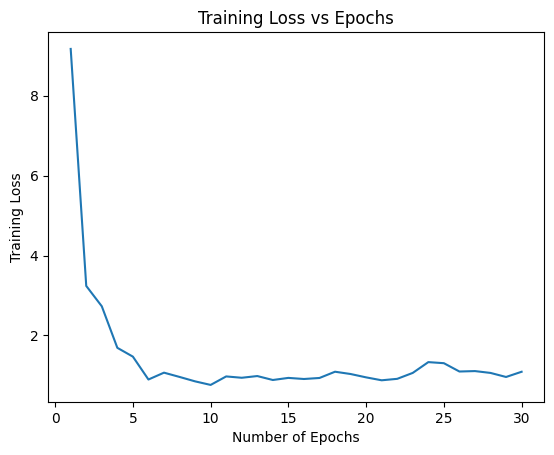

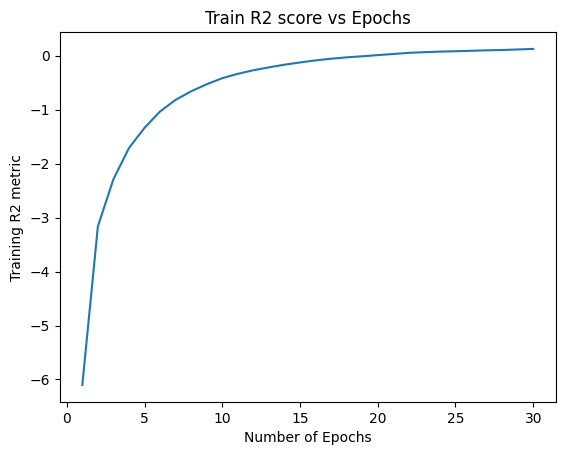

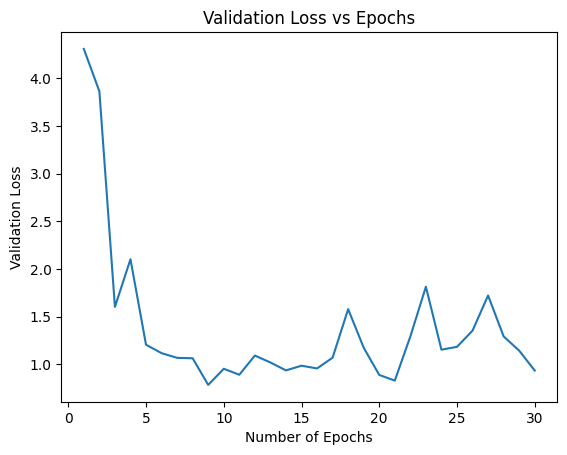

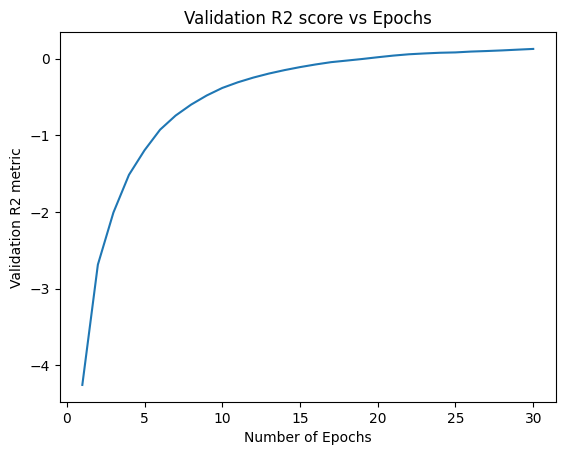

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg = torchvision.models.vgg19(pretrained=True)
model_vgg.classifier[6] = nn.Linear(in_features=4096,out_features=1,bias=True)
for param in model_vgg.classifier[6].parameters():
  param.requires_grad=True
model_vgg.to(device)

from torcheval.metrics import R2Score
optimizer = torch.optim.Adam(model_vgg.classifier[6].parameters(), lr=0.01)
num_epochs=30
loss_fn = torch.nn.MSELoss()

val_loss_arr = []
train_loss_arr = []

val_R2_arr = []
train_R2_arr = []

R2metric = (R2Score()).to(device)

for epoch in range(num_epochs):
    # Train:
    running_loss = 0
    cnt = 0
    R2_train_loss = 0
    for batch_index, (images, labels) in enumerate(train_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = model_vgg(images).flatten()
      loss = loss_fn(output,labels.float())
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      R2metric.update(output,labels)
      R2_train_loss += R2metric.compute()

    epoch_loss = running_loss/cnt
    R2_train_loss /= cnt

    train_loss_arr.append(epoch_loss)
    train_R2_arr.append(R2_train_loss)
    

    # Validation:
    val_loss = 0
    R2_val_loss = 0
    #val_accuracy = 0
    cnt = 0
    cnt2=0
    for batch_index, (images,labels) in enumerate(validation_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      with torch.no_grad():
        output = model_vgg(images).flatten()
        loss = loss_fn(output,labels.float())
        val_loss += loss.item()
        #pred = torch.round(output)
        #val_accuracy += torch.sum(pred==labels).item()
        #cnt2+= images.shape[0]
        R2metric.update(output,labels)
        R2_val_loss += R2metric.compute()
    
      
    #val_accuracy /= cnt2
    epoch_val_loss = val_loss/cnt
    R2_val_loss /= cnt

    val_loss_arr.append(epoch_val_loss)
    val_R2_arr.append(R2_val_loss)

    #print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} Validation Accuracy: {val_accuracy}')
    print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} R2_train_loss: {R2_train_loss} R2_val_loss: {R2_val_loss}')

plt.plot(range(1,num_epochs+1),train_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in train_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Training R2 metric")
plt.title("Train R2 score vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),val_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in val_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Validation R2 metric")
plt.title("Validation R2 score vs Epochs")
plt.show()




LR = 0.005

epoch: 0 Train loss: 7.807318806648254 Validation Loss: 2.077848434448242 R2_train_loss: -6.036904811859131 R2_val_loss: -3.781067371368408
epoch: 1 Train loss: 3.3639364689588547 Validation Loss: 2.3785479068756104 R2_train_loss: -2.9843788146972656 R2_val_loss: -2.4180779457092285
epoch: 2 Train loss: 2.080205738544464 Validation Loss: 2.041585683822632 R2_train_loss: -1.971184253692627 R2_val_loss: -1.7187561988830566
epoch: 3 Train loss: 1.3832596689462662 Validation Loss: 1.8588230609893799 R2_train_loss: -1.4358360767364502 R2_val_loss: -1.2610478401184082
epoch: 4 Train loss: 1.3694829493761063 Validation Loss: 0.9961482286453247 R2_train_loss: -1.0774117708206177 R2_val_loss: -0.9729365110397339
epoch: 5 Train loss: 1.1170097291469574 Validation Loss: 0.988138735294342 R2_train_loss: -0.8521910905838013 R2_val_loss: -0.7579503059387207
epoch: 6 Train loss: 1.0231768637895584 Validation Loss: 0.8230003118515015 R2_train_loss: -0.6648385524749756 R2_val_loss: -0.5971629619598389


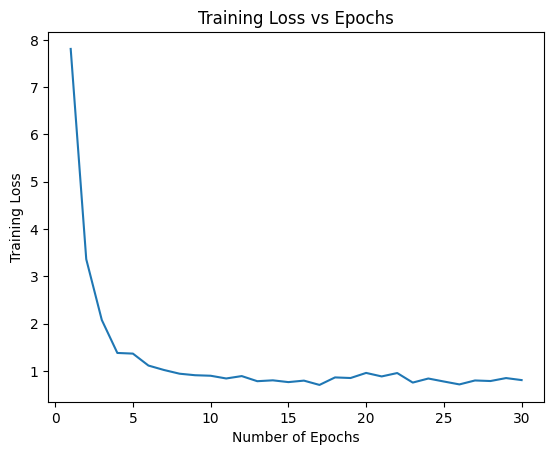

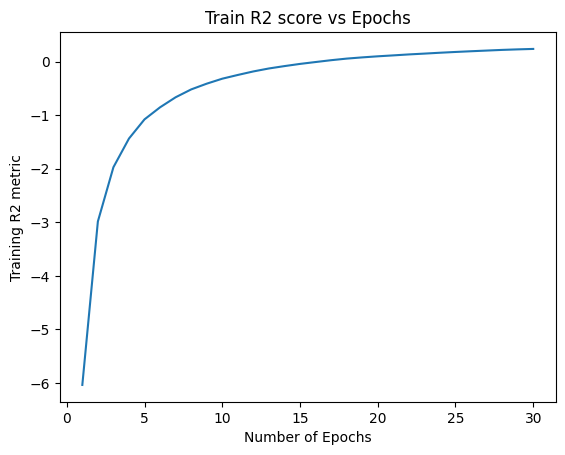

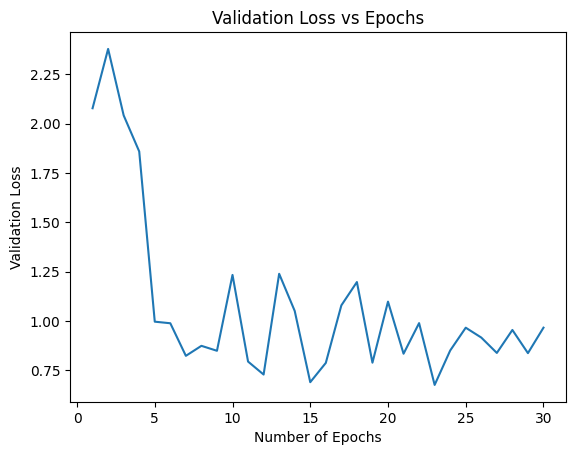

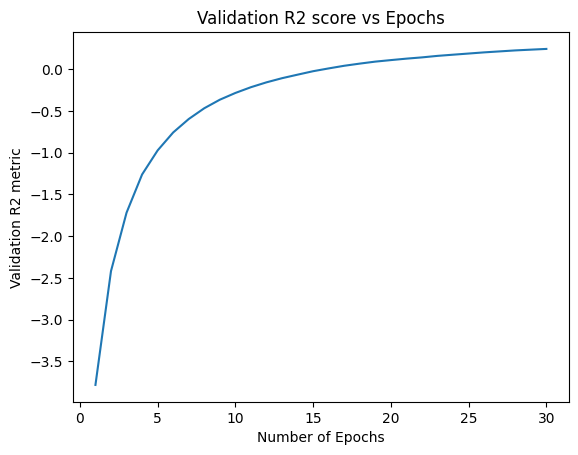

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg = torchvision.models.vgg19(pretrained=True)
model_vgg.classifier[6] = nn.Linear(in_features=4096,out_features=1,bias=True)
for param in model_vgg.classifier[6].parameters():
  param.requires_grad=True
model_vgg.to(device)

from torcheval.metrics import R2Score
optimizer = torch.optim.Adam(model_vgg.classifier[6].parameters(), lr=0.005)
num_epochs=30
loss_fn = torch.nn.MSELoss()

val_loss_arr = []
train_loss_arr = []

val_R2_arr = []
train_R2_arr = []

R2metric = (R2Score()).to(device)

for epoch in range(num_epochs):
    # Train:
    running_loss = 0
    cnt = 0
    R2_train_loss = 0
    for batch_index, (images, labels) in enumerate(train_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = model_vgg(images).flatten()
      loss = loss_fn(output,labels.float())
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      R2metric.update(output,labels)
      R2_train_loss += R2metric.compute()

    epoch_loss = running_loss/cnt
    R2_train_loss /= cnt

    train_loss_arr.append(epoch_loss)
    train_R2_arr.append(R2_train_loss)
    

    # Validation:
    val_loss = 0
    R2_val_loss = 0
    #val_accuracy = 0
    cnt = 0
    cnt2=0
    for batch_index, (images,labels) in enumerate(validation_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      with torch.no_grad():
        output = model_vgg(images).flatten()
        loss = loss_fn(output,labels.float())
        val_loss += loss.item()
        #pred = torch.round(output)
        #val_accuracy += torch.sum(pred==labels).item()
        #cnt2+= images.shape[0]
        R2metric.update(output,labels)
        R2_val_loss += R2metric.compute()
    
      
    #val_accuracy /= cnt2
    epoch_val_loss = val_loss/cnt
    R2_val_loss /= cnt

    val_loss_arr.append(epoch_val_loss)
    val_R2_arr.append(R2_val_loss)

    #print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} Validation Accuracy: {val_accuracy}')
    print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} R2_train_loss: {R2_train_loss} R2_val_loss: {R2_val_loss}')

plt.plot(range(1,num_epochs+1),train_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in train_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Training R2 metric")
plt.title("Train R2 score vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),val_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in val_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Validation R2 metric")
plt.title("Validation R2 score vs Epochs")
plt.show()




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch: 0 Train loss: 10.796213686466217 Validation Loss: 1.7108376026153564 R2_train_loss: -9.005163192749023 R2_val_loss: -5.487954616546631
epoch: 1 Train loss: 2.6365202516317368 Validation Loss: 3.904846668243408 R2_train_loss: -3.824981212615967 R2_val_loss: -3.0570220947265625
epoch: 2 Train loss: 3.199288308620453 Validation Loss: 1.4557342529296875 R2_train_loss: -2.6591529846191406 R2_val_loss: -2.318244218826294
epoch: 3 Train loss: 1.8501237481832504 Validation Loss: 1.686579704284668 R2_train_loss: -1.9490090608596802 R2_val_loss: -1.7288076877593994
epoch: 4 Train loss: 1.6645080894231796 Validation Loss: 1.4496313333511353 R2_train_loss: -1.5138626098632812 R2_val_loss: -1.3794052600860596
epoch: 5 Train loss: 1.2182123139500618 Validation Loss: 1.3245084285736084 R2_train_loss: -1.2214572429656982 R2_val_loss: -1.1013412475585938
epoch: 6 Train loss: 1.2509144321084023 Validation Loss: 1.0805437564849854 R2_train_loss: -0.9988951086997986 R2_val_loss: -0.9054263830184937

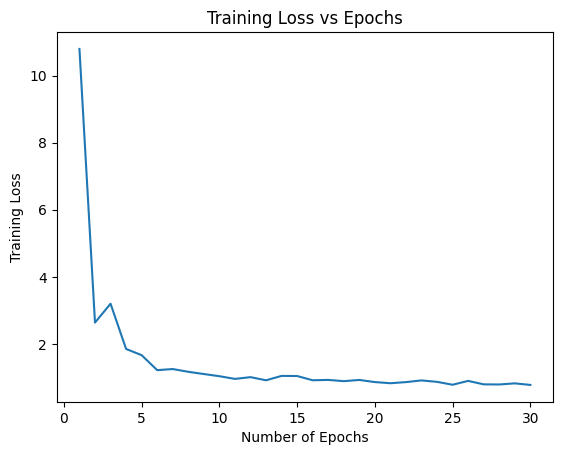

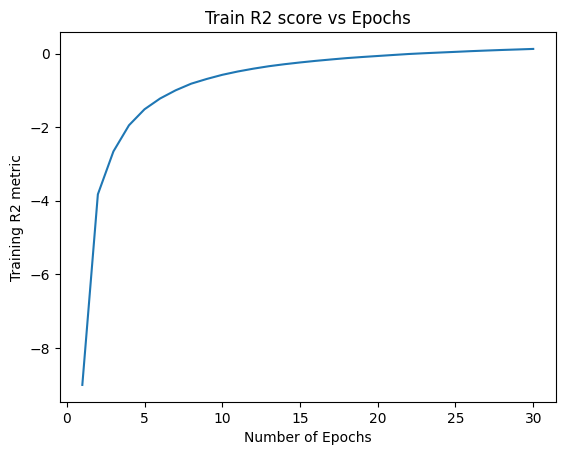

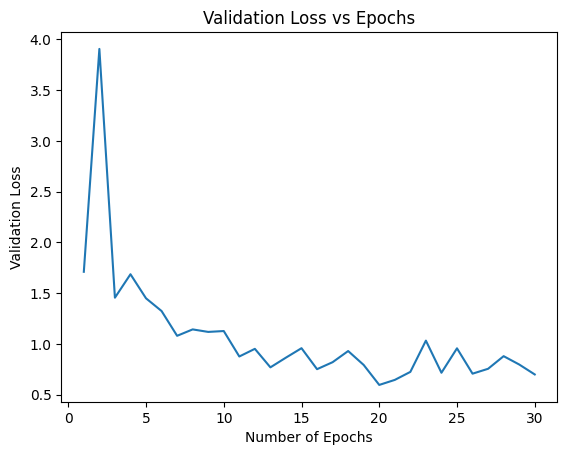

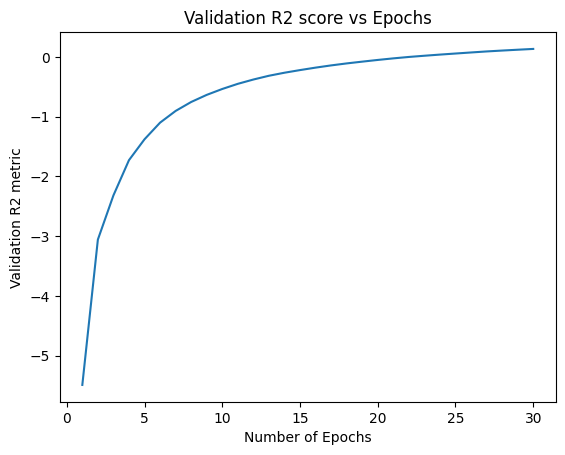

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg = torchvision.models.vgg19(pretrained=True)
model_vgg.classifier[6] = nn.Linear(in_features=4096,out_features=1,bias=True)
for param in model_vgg.classifier[6].parameters():
  param.requires_grad=True
model_vgg.to(device)

from torcheval.metrics import R2Score
optimizer = torch.optim.Adam(model_vgg.classifier[6].parameters(), lr=0.001)
num_epochs=30
loss_fn = torch.nn.MSELoss()

val_loss_arr = []
train_loss_arr = []

val_R2_arr = []
train_R2_arr = []

R2metric = (R2Score()).to(device)

for epoch in range(num_epochs):
    # Train:
    running_loss = 0
    cnt = 0
    R2_train_loss = 0
    for batch_index, (images, labels) in enumerate(train_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = model_vgg(images).flatten()
      loss = loss_fn(output,labels.float())
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      R2metric.update(output,labels)
      R2_train_loss += R2metric.compute()

    epoch_loss = running_loss/cnt
    R2_train_loss /= cnt

    train_loss_arr.append(epoch_loss)
    train_R2_arr.append(R2_train_loss)
    

    # Validation:
    val_loss = 0
    R2_val_loss = 0
    #val_accuracy = 0
    cnt = 0
    cnt2=0
    for batch_index, (images,labels) in enumerate(validation_loader):
      cnt+=1
      images = images.to(device)
      labels = labels.to(device)
      with torch.no_grad():
        output = model_vgg(images).flatten()
        loss = loss_fn(output,labels.float())
        val_loss += loss.item()
        #pred = torch.round(output)
        #val_accuracy += torch.sum(pred==labels).item()
        #cnt2+= images.shape[0]
        R2metric.update(output,labels)
        R2_val_loss += R2metric.compute()
    
      
    #val_accuracy /= cnt2
    epoch_val_loss = val_loss/cnt
    R2_val_loss /= cnt

    val_loss_arr.append(epoch_val_loss)
    val_R2_arr.append(R2_val_loss)

    #print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} Validation Accuracy: {val_accuracy}')
    print(f'epoch: {epoch} Train loss: {epoch_loss} Validation Loss: {epoch_val_loss} R2_train_loss: {R2_train_loss} R2_val_loss: {R2_val_loss}')

plt.plot(range(1,num_epochs+1),train_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in train_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Training R2 metric")
plt.title("Train R2 score vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),val_loss_arr)
plt.xlabel("Number of Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epochs")
plt.show()

plt.plot(range(1,num_epochs+1),[i.to('cpu') for i in val_R2_arr])
plt.xlabel("Number of Epochs")
plt.ylabel("Validation R2 metric")
plt.title("Validation R2 score vs Epochs")
plt.show()




In [30]:
torch.save(model_vgg,"./drive/MyDrive/model_fial.t")

In [29]:
!cp model_fial.t ./drive/MyDrive/

NotImplementedError: ignored

In [ ]:
annotations_file = "train/annotations.xlsx"
anno_file = pd.read_excel(annotations_file)

img1 = torchvision.io.read_image('train/images/Image_0250_05_0_0_6.png')
img1 = img1[:-1]
img1[2]
anno_file.iloc[0,1]

'Image_0000_04_0_0_4.png'

In [ ]:
image1 = torch.

In [ ]:

device

device(type='cpu')

In [ ]:
model_vgg = torchvision.models.vgg19(pretrained=True)
model_vgg

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 88.1MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
model_vgg.classifier[6] = nn.Linear(in_features=4096,out_features=1,bias=True)
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Archive:  train.zip
 extracting: train/annotations.xlsx  
 extracting: train/images/Image_0000_04_0_0_4.png  
 extracting: train/images/Image_0001_04_0_0_4.png  
 extracting: train/images/Image_0002_04_0_0_4.png  
 extracting: train/images/Image_0003_04_0_0_4.png  
 extracting: train/images/Image_0004_04_0_0_4.png  
 extracting: train/images/Image_0005_04_0_0_4.png  
 extracting: train/images/Image_0006_04_0_0_4.png  
 extracting: train/images/Image_0007_04_0_0_4.png  
 extracting: train/images/Image_0008_04_0_0_4.png  
 extracting: train/images/Image_0009_04_0_0_4.png  
 extracting: train/images/Image_0010_04_0_0_4.png  
 extracting: train/images/Image_0011_04_0_0_4.png  
 extracting: train/images/Image_0012_04_0_0_4.png  
 extracting: train/images/Image_0013_04_0_0_4.png  
 extracting: train/images/Image_0014_04_0_0_4.png  
 extracting: train/images/Image_0015_04_0_0_4.png  
 extracting: train/images/Image_0016_04_0_0_4.png  
 extracting: train/images/Image_0017_04_0_0_4.png  
 extra